# IRIS

In [1]:
import shapely
import shapely.geometry
from shapely.strtree import STRtree
import shapefile
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, pow, log, pi, tan, exp
from pyproj import Proj, transform, CRS
import time

In [2]:
folder="/mnt/c/Users/guera/projects/E-CUBE"

poste_elec = pd.read_csv(folder+"/data/postes-electriques-rte.csv", sep=';')
siren_eta_geo = pd.read_csv(folder+"/data/SIREN/StockEtablissementActif_utf8_geo.csv", sep=',',usecols=["siren", "siret", "codeCommuneEtablissement", "longitude", "latitude"])
siren_ul = pd.read_csv(folder+"/data/SIREN/StockUniteLegale_utf8.csv", sep=',',usecols=["siren", "categorieJuridiqueUniteLegale"])

/home/guera/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


On retire de la liste des établissements SIRENE les entreprises représentant des personnes physiques qui ne nous intéressent pas pour la consommation électrique

In [3]:
siren = siren_eta_geo.merge(siren_ul)
siren_without_auto = siren.loc[siren.loc[:, "categorieJuridiqueUniteLegale"] != 1000]

In [4]:
siren_eta_geo.shape

(11810235, 5)

In [5]:
siren_ul.shape

(21111921, 2)

In [6]:
siren.shape

(11810235, 6)

In [7]:
siren_without_auto.shape

(7383430, 6)

In [8]:
siren.head()

,siren,siret,codeCommuneEtablissement,longitude,latitude,categorieJuridiqueUniteLegale
0,15850944,1585094400024,1376,4.989048,45.823935,5720
1,15850944,1585094400016,21295,4.992864,47.228989,5720
2,15851793,1585179300479,1134,4.904811,46.282463,5699
3,15851793,1585179300743,1057,4.913975,46.407388,5699
4,15851793,1585179300917,1053,5.228366,46.220760,5699


On charge les contours d'IRIS pour la France métropolitaine puis pour les régions d'outre-mer

In [9]:
file_name_metro="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019/CONTOURS-IRIS.shp"

sh_metro = shapefile.Reader(file_name_metro)
shapes_metro= sh_metro.shapes()

In [10]:
file_name_guad="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_GLP-2019/CONTOURS-IRIS.shp"

sh_guad = shapefile.Reader(file_name_guad)
shapes_guad= sh_guad.shapes()

In [11]:
file_name_mart="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_MTQ-2019/CONTOURS-IRIS.shp"

sh_mart = shapefile.Reader(file_name_mart)
shapes_mart= sh_mart.shapes()

In [12]:
file_name_may="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGM04UTM38S_MYT-2019/CONTOURS-IRIS.shp"

sh_may = shapefile.Reader(file_name_may)
shapes_may= sh_may.shapes()

In [13]:
file_name_reu="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGR92UTM40S_REU-2019/CONTOURS-IRIS.shp"

sh_reu = shapefile.Reader(file_name_reu)
shapes_reu= sh_reu.shapes()

In [14]:
file_name_guy="/mnt/c/Users/guera/projects/E-CUBE/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_UTM22RGFG95_GUF-2019/CONTOURS-IRIS.shp"

sh_guy = shapefile.Reader(file_name_guy)
shapes_guy= sh_guy.shapes()

In [15]:
from simpledbf import Dbf5
iris_metro_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019/CONTOURS-IRIS.dbf")
iris_metro_df=iris_metro_dbf.to_dataframe()

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [16]:
iris_guad_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_GLP-2019/CONTOURS-IRIS.dbf")
iris_guad_df=iris_guad_dbf.to_dataframe()

In [17]:
iris_mart_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_MTQ-2019/CONTOURS-IRIS.dbf")
iris_mart_df=iris_mart_dbf.to_dataframe()

In [18]:
iris_may_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGM04UTM38S_MYT-2019/CONTOURS-IRIS.dbf")
iris_may_df=iris_may_dbf.to_dataframe()

In [19]:
iris_reu_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGR92UTM40S_REU-2019/CONTOURS-IRIS.dbf")
iris_reu_df=iris_reu_dbf.to_dataframe()

In [20]:
iris_guy_dbf=Dbf5(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_UTM22RGFG95_GUF-2019/CONTOURS-IRIS.dbf")
iris_guy_df=iris_guy_dbf.to_dataframe()

In [21]:
list_metro=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019/LISTE.csv", sep=';')
list_guad=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_GLP-2019/LISTE.csv", sep=';')
list_mart=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGAF09UTM20_MTQ-2019/LISTE.csv", sep=';')
list_may=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGM04UTM38S_MYT-2019/LISTE.csv", sep=';')
list_reu=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_RGR92UTM40S_REU-2019/LISTE.csv", sep=';')
list_guy=pd.read_csv(folder+"/data/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2020-01-00139/CONTOURS-IRIS_2-1_SHP_UTM22RGFG95_GUF-2019/LISTE.csv", sep=';')

list_cp=pd.concat([list_metro,list_guad,list_mart,list_may,list_reu,list_guy],axis=0)

print(list_cp.shape)
list_cp

(1936, 3)


,INSEE_COM,NOM_COM,NB_IRIS
0,01004,Ambérieu-en-Bugey,4
1,01033,Valserhône,6
2,01034,Belley,3
3,01053,Bourg-en-Bresse,18
4,01143,Divonne-les-Bains,3
...,...,...,...
2,97305,Macouria,2
3,97306,Mana,2
4,97307,Matoury,8
5,97309,Remire-Montjoly,6


In [23]:
cp=iris_metro_df.loc[0,"INSEE_COM"]
print(cp)
print(type(cp))
nb=list_metro.loc[list_metro["INSEE_COM"]== cp]
print(nb)

72191
<class 'str'>
Empty DataFrame
Columns: [INSEE_COM, NOM_COM, NB_IRIS]
Index: []


On crée maintenant des arbres STR par région

In [24]:
STRlist=[STRtree([]) for i in range(101)]

In [25]:
p=[([],{}) for i in range(101)]

for i in range(len(shapes_metro)):
    dep=iris_metro_df.loc[i,"INSEE_COM"][:2]
    if dep=='2A':
        dep='20'
    elif dep=='2B':
        dep='96'
    poly=shapely.geometry.Polygon(shapes_metro[i].points)
    p[int(dep)-1][1][id(poly)]=iris_metro_df.loc[i,"CODE_IRIS"]
    p[int(dep)-1][0].append(poly)
    
    
for i in range(len(shapes_guad)):
    poly=shapely.geometry.Polygon(shapes_guad[i].points)
    p[96][1][id(poly)]=iris_guad_df.loc[i,"CODE_IRIS"]
    p[96][0].append(poly)
    

for i in range(len(shapes_mart)):
    poly=shapely.geometry.Polygon(shapes_mart[i].points)
    p[97][1][id(poly)]=iris_mart_df.loc[i,"CODE_IRIS"]
    p[97][0].append(poly)
    

for i in range(len(shapes_guy)):
    poly=shapely.geometry.Polygon(shapes_guy[i].points)
    p[98][1][id(poly)]=iris_guy_df.loc[i,"CODE_IRIS"]
    p[98][0].append(poly)
    
    
for i in range(len(shapes_reu)):
    poly=shapely.geometry.Polygon(shapes_reu[i].points)
    p[99][1][id(poly)]=iris_reu_df.loc[i,"CODE_IRIS"]
    p[99][0].append(poly)
    
    
for i in range(len(shapes_may)):
    poly=shapely.geometry.Polygon(shapes_may[i].points)
    p[100][1][id(poly)]=iris_may_df.loc[i,"CODE_IRIS"]
    p[100][0].append(poly)
    
    
for i in range(101):
    STRlist[i]=STRtree(p[i][0])

In [26]:
#Lambert 93 -> France Metropolitaine
crs_L93 = CRS.from_epsg(2154)
L93_Proj = Proj(crs_L93)

#WGS -> coordonnées longitude, latitude
crs_WGS = CRS.from_epsg(4326)
WGS_Proj = Proj(crs_WGS)

#RGAF09UTM20 -> Antilles Françaises (Guadeloupe, Martinique)
crs_RGAF09UTM20 = CRS.from_epsg(5490)
RGAF09UTM20_Proj = Proj(crs_RGAF09UTM20)

#RGFG95UTM22 -> Guyane française
crs_RGFG95UTM22 = CRS.from_epsg(2972)
RGFG95UTM22_Proj = Proj(crs_RGFG95UTM22)

#RGR92UTM40S -> Réunion
crs_RGR92UTM40S = CRS.from_epsg(2975)
RGR92UTM40S_Proj = Proj(crs_RGR92UTM40S)

#RGM04UTM38S -> Mayotte
crs_RGM04UTM38S = CRS.from_epsg(4471)
RGM04UTM38S_Proj = Proj(crs_RGM04UTM38S)

def shape_iris(lat,lon,dep):
    if dep<96:
        x2,y2 = transform(WGS_Proj,L93_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    elif dep==96:
        x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    elif dep==97:
        x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    elif dep==98:
        x2,y2 = transform(WGS_Proj,RGFG95UTM22_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    elif dep==99:
        x2,y2 = transform(WGS_Proj,RGR92UTM40S_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    elif dep==100:
        x2,y2 = transform(WGS_Proj,RGM04UTM38S_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=STRlist[dep].query(query_geom)
    return ir

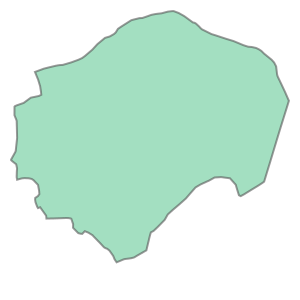

In [27]:
shape_iris(47.78,0.28,71)[0]

In [28]:
def iris(lat,lon,dep):
    ir=shape_iris(lat,lon,dep)
    if ir==[]:
        return None
    idir=p[dep][1][id(ir[0])]
    return idir


In [29]:
iris_metro_df.loc[0,"CODE_IRIS"]

'721910000'

In [30]:
iris(47.78,0.28,71)

'721910000'

In [45]:
def dep(code):
    if len(code)==5:
        nb_dep=code[:2]
        if nb_dep=='2A':
            nb_dep='20'
        elif nb_dep=='2B':
            nb_dep='96'
        elif nb_dep=='97':
            c=code[2]
            if c=='1':
                nb_dep='97'
            elif c=='2':
                nb_dep='98'
            elif c=='3':
                nb_dep='99'
            elif c=='4':
                nb_dep='100'
            elif c=='5':
                nb_dep='101'
    elif len(code)==4:
        nb_dep=code[:1]
    return (int(nb_dep)-1)

dep('97400')

Str=np.vectorize(str)

In [42]:
siren_without_auto=siren_without_auto.head(100)

In [46]:
def time_vect():
    t0=time.time()

    siren_without_auto["IRIS"]=np.vectorize(iris)(siren_without_auto["latitude"],siren_without_auto["longitude"],np.vectorize(dep)(Str(siren_without_auto["codeCommuneEtablissement"])))
    t1=time.time()
    return(t1-t0)

print(time_vect())    
siren_without_auto

TypeError: 'str' object is not callable

In [38]:
siren_without_auto.to_csv(folder+"/data/SIREN/StockEtablissementActif_utf8_geo_iris.csv")

In [47]:
def time_map():
    t0=time.time()
    DEP=map(dep,map(str,siren_without_auto["codeCommuneEtablissement"]))
    IRIS=map(iris,siren_without_auto["latitude"],siren_without_auto["longitude"],DEP)
    siren_without_auto["IRIS"]=(list(IRIS))
    t1=time.time()
    return(t1-t0)

print(time_map())
siren_without_auto

TypeError: 'str' object is not callable

In [64]:
[time_vect()-time_map() for i in range(10)]

[1.7252912521362305,
 -0.09824180603027344,
 0.85235595703125,
 0.3761711120605469,
 -0.373779296875,
 0.6094419956207275,
 0.41860389709472656,
 0.46794772148132324,
 0.4111182689666748,
 -0.21510696411132812]

On essaie une autre méthode en réalisant un premier tri non plus par départements mais par communes

In [32]:
listcc=[]
listshape=[]
listiris=[]

for i in range(len(shapes_metro)):
    cc=iris_metro_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_metro[i].points)
    iris=iris_metro_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)
    
for i in range(len(shapes_guad)):
    cc=iris_guad_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_guad[i].points)
    iris=iris_guad_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)

for i in range(len(shapes_mart)):
    cc=iris_mart_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_mart[i].points)
    iris=iris_mart_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)
    
for i in range(len(shapes_may)):
    cc=iris_may_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_may[i].points)
    iris=iris_may_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)
    
for i in range(len(shapes_reu)):
    cc=iris_reu_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_reu[i].points)
    iris=iris_reu_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)
    
for i in range(len(shapes_guy)):
    cc=iris_guy_df.loc[i,"INSEE_COM"]
    poly=shapely.geometry.Polygon(shapes_guy[i].points)
    iris=iris_guy_df.loc[i,"CODE_IRIS"]
    listcc.append(cc)
    listshape.append(poly)
    listiris.append(iris)

communes=pd.DataFrame({'code commune':listcc, 'contour iris':listshape, 'iris':listiris})
communes

,code commune,contour iris,iris
0,72191,"POLYGON ((497887.4 6747662.4, 497907.2 6747658...",721910000
1,77248,"POLYGON ((685757.7 6868592.3, 685832.5 6868319...",772480000
2,51426,"POLYGON ((757292.9 6847598.4, 757334.3 6847081...",514260000
3,81199,"POLYGON ((646146.9 6328153.2, 646124.9 6328229...",811990000
4,59225,"POLYGON ((767596 7022269.1, 767242.2 7022129.4...",592250102
...,...,...,...
49399,97307,"POLYGON ((351503 534810.5, 351509.2 534806.5, ...",973070105
49400,97311,"POLYGON ((164025.4 609416.5, 164105.7 609443.7...",973110101
49401,97307,"POLYGON ((348751.6 542027.1, 348758.9 542017.3...",973070108
49402,97362,"POLYGON ((130962.6 457860.7, 131036.1 457823.7...",973620000


In [122]:
#On prend un couple de coordonnées
def iris_commune(i):
    x2,y2=0,0
    cc=str(siren_without_auto.loc[i,"codeCommuneEtablissement"])
    if len(cc)==4:
        cc='0'+cc
    recherche_iris=communes.loc[communes["code commune"]==cc]
    if len(recherche_iris) == 1:
        return recherche_iris.iloc[0,2]
    else:
        poly=list(recherche_iris.iloc[:,1])
        tree=STRtree(poly)
        lat=siren_without_auto.loc[i,"latitude"]
        lon=siren_without_auto.loc[i,"longitude"]
        if cc[:2]=='97':
            if cc[2]=='1':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='2':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='3':
                x2,y2 = transform(WGS_Proj,RGFG95UTM22_Proj,lat,lon)
            elif cc[2]=='4':
                x2,y2 = transform(WGS_Proj,RGR92UTM40S_Proj,lat,lon)
            elif cc[2]=='5':
                x2,y2 = transform(WGS_Proj,RGM04UTM38S_Proj,lat,lon)
        else:
            x2,y2 = transform(WGS_Proj,L93_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=tree.query(query_geom)
        if ir==[]:
            return None
        return recherche_iris.loc[recherche_iris["contour iris"]==ir[0]].iloc[0,2]

iris_commune(4)

'010530604'

In [56]:
def iris_commune_boucle(i):
    l=[]
    for i in range(i):
        l.append(iris_commune(i))
    return pd.Series(l)
        

In [123]:
iris_commune_boucle()

0     013760000
1     212950000
2     011340000
3     010570000
4     010530604
        ...    
95    633000111
96    682940000
97    692780000
98    692640402
99    693830401
Length: 100, dtype: object

In [196]:
def time_commune():
    t0=time.time()

    siren_without_auto["IRIS"]=iris_commune_boucle(100)
    t1=time.time()
    return(t1-t0)

print(time_commune())    
siren_without_auto

6.201423406600952


/home/guera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,siren,siret,codeCommuneEtablissement,longitude,latitude,categorieJuridiqueUniteLegale,IRIS
0,15850944,1585094400024,1376,4.989048,45.823935,5720,013760000
1,15850944,1585094400016,21295,4.992864,47.228989,5720,212950000
2,15851793,1585179300479,1134,4.904811,46.282463,5699,011340000
3,15851793,1585179300743,1057,4.913975,46.407388,5699,010570000
4,15851793,1585179300917,1053,5.228366,46.220760,5699,010530604
...,...,...,...,...,...,...,...
11810228,882702632,88270263200010,NaN,NaN,NaN,3220,NaN
11810229,946250693,94625069300029,NaN,NaN,NaN,3120,NaN
11810231,950007575,95000757500018,NaN,NaN,NaN,3120,NaN
11810232,950051607,95005160700014,NaN,NaN,NaN,3220,NaN


In [41]:
def iris_commune_bis(lat,lon,cc):
    cc=str(cc)
    if len(cc)==4:
        cc='0'+cc
    recherche_iris=communes.loc[communes["code commune"]==cc]
    if len(recherche_iris) == 1:
        return recherche_iris.iloc[0,2]
    else:
        poly=list(recherche_iris.iloc[:,1])
        tree=STRtree(poly)
        if cc[:2]=='97':
            if cc[2]=='1':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='2':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='3':
                x2,y2 = transform(WGS_Proj,RGFG95UTM22_Proj,lat,lon)
            elif cc[2]=='4':
                x2,y2 = transform(WGS_Proj,RGR92UTM40S_Proj,lat,lon)
            elif cc[2]=='5':
                x2,y2 = transform(WGS_Proj,RGM04UTM38S_Proj,lat,lon)
        else:
            x2,y2 = transform(WGS_Proj,L93_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=tree.query(query_geom)
        return recherche_iris.loc[recherche_iris["contour iris"]==ir[0]].iloc[0,2]

iris_commune_bis(45,5,26004)

'260040000'

In [52]:
def time_commune_no_loop():
    t0=time.time()

    siren_without_auto["IRIS"]=np.vectorize(iris_commune_bis)(siren_without_auto["latitude"],siren_without_auto["longitude"],siren_without_auto["codeCommuneEtablissement"])
    t1=time.time()
    return(t1-t0)

print(time_commune_no_loop())    
siren_without_auto

8.119361877441406


,siren,siret,codeCommuneEtablissement,longitude,latitude,categorieJuridiqueUniteLegale,IRIS
0,15850944,1585094400024,1376,4.989048,45.823935,5720,013760000
1,15850944,1585094400016,21295,4.992864,47.228989,5720,212950000
2,15851793,1585179300479,1134,4.904811,46.282463,5699,011340000
3,15851793,1585179300743,1057,4.913975,46.407388,5699,010570000
4,15851793,1585179300917,1053,5.228366,46.220760,5699,010530604
...,...,...,...,...,...,...,...
95,16250029,1625002900788,63300,3.146462,45.896573,5510,633000111
96,16250029,1625002900911,68294,NaN,NaN,5510,682940000
97,16250029,1625002900630,69278,4.840554,45.897925,5510,692780000
98,16250029,1625002900655,69264,4.718077,45.979110,5510,692640402


In [199]:
siren = siren_eta_geo.merge(siren_ul)
siren_without_auto = siren.loc[siren.loc[:, "categorieJuridiqueUniteLegale"] != 1000]
siren_without_auto_iris = pd.read_csv(folder+"/data/SIREN/StockEtablissementActif_utf8_geo_iris.csv")
#siren_without_auto_iris = pd.DataFrame([],columns=pd.Index(['siren', 'siret', 'codeCommuneEtablissement', 'longitude', 'latitude',
#       'categorieJuridiqueUniteLegale','IRIS']))

In [236]:
siren_without_auto_iris

,Unnamed: 0,Unnamed: 0.1,siren,siret,codeCommuneEtablissement,longitude,latitude,categorieJuridiqueUniteLegale,IRIS
0,0.0,0.0,15850944,1585094400024,1376,4.989048,45.823935,5720,013760000
1,1.0,1.0,15850944,1585094400016,21295,4.992864,47.228989,5720,212950000
2,2.0,2.0,15851793,1585179300479,1134,4.904811,46.282463,5699,011340000
3,3.0,3.0,15851793,1585179300743,1057,4.913975,46.407388,5699,010570000
4,4.0,4.0,15851793,1585179300917,1053,5.228366,46.220760,5699,010530604
...,...,...,...,...,...,...,...,...,...
3451142,NaN,NaN,484691027,48469102700011,33199,-1.051480,44.643238,5499,331990104
3451143,NaN,NaN,484691258,48469125800020,33056,-0.613617,44.932458,5710,330560107
3451146,NaN,NaN,484692058,48469205800023,33192,-0.642574,44.776057,5499,331920108
3451147,NaN,NaN,484692520,48469252000014,33442,-0.235915,45.013873,6534,334420000


In [228]:
def save(a,nb):
    global siren_without_auto
    global siren_without_auto_iris
    l=len(siren_without_auto)
    for j in range(nb):
        t0=time.time()
        df=siren_without_auto.iloc[(a + 10000*j):(a + 10000*(j+1)),:].copy()
        df['IRIS']=0
        for i in range(10000):
            if (a + 10000*j + i) == l:
                break
            df.iloc[i,6]=iris_commune_dict(siren_without_auto.index[a + 10000*j + i])
        t1=time.time()
        print(t1-t0)
        print(j+1)
        siren_without_auto_iris=pd.concat([siren_without_auto_iris,df], axis=0)
        siren_without_auto_iris.to_csv(folder+"/data/SIREN/StockEtablissementActif_utf8_geo_iris.csv")

In [ ]:
save(2100000,10)

509.4559848308563
0
315.43764328956604
1
296.95026087760925
2
611.7288539409637
3
770.2744135856628
4
764.5624463558197
5
722.6478989124298
6
734.2943074703217
7


In [177]:
d={}
for i in range(len(communes)):
    try:
        (p,l)=d[communes.iloc[i,0]]
    except:
        p,l=[],[]
    poly = communes.iloc[i,1]
    iris=communes.iloc[i,2]
    p.append(poly)
    l.append(iris)
    d[communes.iloc[i,0]] = (p,l)

for i in d:
    p,l=d[i]    
    t=STRtree(p)
    lex=dict((id(p[i]),l[i]) for i in range(len(p)))
    d[i]=(lex,t)

In [189]:
list(d['26004'][0].values())[0]

'260040000'

In [201]:
def iris_commune_dict(i):
    x2,y2=0,0
    cc=str(siren_without_auto.loc[i,"codeCommuneEtablissement"])
    if len(cc)==4:
        cc='0'+cc
    try:
        lex,tree=d[cc]
    except:
        return None
    if len(lex) == 1:
        return list(lex.values())[0]
    else:
        lat=siren_without_auto.loc[i,"latitude"]
        lon=siren_without_auto.loc[i,"longitude"]
        if cc[:2]=='97':
            if cc[2]=='1':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='2':
                x2,y2 = transform(WGS_Proj,RGAF09UTM20_Proj,lat,lon)
            elif cc[2]=='3':
                x2,y2 = transform(WGS_Proj,RGFG95UTM22_Proj,lat,lon)
            elif cc[2]=='4':
                x2,y2 = transform(WGS_Proj,RGR92UTM40S_Proj,lat,lon)
            elif cc[2]=='5':
                x2,y2 = transform(WGS_Proj,RGM04UTM38S_Proj,lat,lon)
        else:
            x2,y2 = transform(WGS_Proj,L93_Proj,lat,lon)
        query_geom=shapely.geometry.Point(x2,y2)
        ir=tree.query(query_geom)
        if ir==[]:
            return None
        return lex[id(ir[0])]

iris_commune_dict(4)

'010530604'

In [197]:
def iris_commune_boucle_dict(nb):
    l=[]
    for i in range(nb):
        l.append(iris_commune_dict(i))
    return pd.Series(l)

def time_commune_dict():
    t0=time.time()

    siren_without_auto["IRIS"]=iris_commune_boucle_dict(100)
    t1=time.time()
    return(t1-t0)

print(time_commune_dict())    
siren_without_auto


print(time_commune())    
siren_without_auto

/home/guera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


5.2807252407073975
6.457460880279541


/home/guera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,siren,siret,codeCommuneEtablissement,longitude,latitude,categorieJuridiqueUniteLegale,IRIS
0,15850944,1585094400024,1376,4.989048,45.823935,5720,013760000
1,15850944,1585094400016,21295,4.992864,47.228989,5720,212950000
2,15851793,1585179300479,1134,4.904811,46.282463,5699,011340000
3,15851793,1585179300743,1057,4.913975,46.407388,5699,010570000
4,15851793,1585179300917,1053,5.228366,46.220760,5699,010530604
...,...,...,...,...,...,...,...
11810228,882702632,88270263200010,NaN,NaN,NaN,3220,NaN
11810229,946250693,94625069300029,NaN,NaN,NaN,3120,NaN
11810231,950007575,95000757500018,NaN,NaN,NaN,3120,NaN
11810232,950051607,95005160700014,NaN,NaN,NaN,3220,NaN
